# Project - Grinding Dynamic Simulation Model

In [2]:
from platform import python_version
python_version()

'3.7.6'

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

In [4]:
plot_dir = 'plots'
data_dir = 'data'

## Grinding Model Differential Equations

In [5]:
def f_dxdt(t, x, feed, r, b_matrix, d):
    """Ordinary differential equations describing the rate of change of
    mill charge in each size fraction.  This is the 'General Grinding
    Model' described in Molycop Tools spreadsheet (Eq. 3).  Note, t is
    redundant in this case but is included for compatibility with
    numerical solvers which are designed for the general case where dxdt
    can be a function of time also.
    
    Args:
        t (float): Time (mins).
        x (array): Charge load (tons).
        feed (np.ndarray): Mill feed (tons).
        r (array): Breakage rates (selection function).
        b_matrix (array): Breakage matrix (appearance functions).
        d (array): Discharge grate efficiencies.
    """
    A = r*(b_matrix - np.eye(b_matrix.shape[0])) - np.diag(d)
    return feed + A @ x

In [6]:
def solve(t, x0, dxdt, timestep_size, args, method='Radau'):
    """Estimates x at time t + timestep by starting at x0 and
    using the derivate function dxdt to numerically solve the
    initial value problem.
    
    Args:
        t: (float): Initial time.
        x0 (array): Initial x at time t (i.e. x[t]). 
        dxdt (function): Function which returns the derivative of x.
        timestep_size (float): Timestep to increment by.
        args (list): Additional arguments to pass to dxdt.
    
    Returns:
        x2 (array): State vector at time t + timestep_size.
    """
    t2 = t + timestep_size
    sol = solve_ivp(dxdt, t_span=[t, t2], y0=x0, method=method,
                    args=args)
    assert sol.status == 0, "Solver failed."

    return sol.y[:, -1]

## Unit Tests

In [7]:
# Calculation example with 3 size intervals

# Feed rates
feed = np.array([ 2,  1,  0.5])

# Discharge rate function
d_max = 0.2  # Transport to grate
c = np.array([  0, 0.5, 1.0])  # Grate classification function
d = d_max * c

# Breakage rates
r = np.array([0.2, 0.25, 0.0])

assert r[-1] == 0.0  # r=0 for smallest size fraction
assert all((r + d) <= 1)

# Initial charge
x0 = np.array([30, 30, 30])

# Breakage matrix
b_matrix = np.array([
    [  0,   0,   0],
    [0.5,   0,   0],
    [0.5, 1.0,   0]
])

assert all(sum(b_matrix)[:-1] == 1)

n_sizes = x0.shape[0]
assert feed.shape == (n_sizes, )
assert d.shape == (n_sizes, )
assert r.shape == (n_sizes, )

In [8]:
# Test derivative calculations
t = 0
dxdt = f_dxdt(t, x0, feed, r, b_matrix, d)
dxdt

array([-4. , -6.5,  5. ])

In [9]:
# Rate of change of charge - size 1
dxdt1_true = (feed[0] - x0[0] * r[0]) * (1 - d[0])
assert dxdt[0] == dxdt1_true
dxdt[0], dxdt1_true

(-4.0, -4.0)

In [10]:
breakage = x0 * r
discharge = x0 * d

In [11]:
# Rate of change of charge - size 2
dxdt2_true = (feed[1]
    + breakage[0] * b_matrix[1, 0]
    - breakage[1]
    - discharge[1]
)
assert dxdt[1] == dxdt2_true
dxdt[1], dxdt2_true

(-6.5, -6.5)

In [12]:
# Rate of change of charge - size 3
dxdt3_true = (feed[2]
    + breakage[0] * b_matrix[2, 0]
    + breakage[1] * b_matrix[2, 1]
    - breakage[2]
    - discharge[2]
)
assert np.isclose(dxdt[2], dxdt3_true)
dxdt[2], dxdt3_true

(5.0, 5.0)

In [13]:
# How to calculate discharge rate
discharge_rate = d*x0
discharge_rate

array([0., 3., 6.])

In [14]:
# Mill flows
np.stack([feed, dxdt, discharge]).T

array([[ 2. , -4. ,  0. ],
       [ 1. , -6.5,  3. ],
       [ 0.5,  5. ,  6. ]])

In [15]:
# Check overall mass balance
print(feed.sum(), dxdt.sum(), discharge_rate.sum())
assert dxdt.sum() == feed.sum() - discharge_rate.sum()

3.5 -5.5 9.0


In [16]:
# Test solver
t = 0
timestep_size = 0.5
x1 = solve(t, x0, f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
x1

array([28.09674836, 26.97283772, 32.14492609])

In [17]:
# Test solution with difference estimates
t = 0
timestep_size = 0.01  # Small timestep
x1 = solve(t, x0, f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
dxdt_est = (x1 - x0) / timestep_size
dxdt_true = f_dxdt(t, x0, feed, r, b_matrix, d)

assert np.isclose(dxdt_est, dxdt_true, atol=0.05).all()

print(dxdt_est, dxdt_true)

[-3.99600267 -6.4906346   4.98489421] [-4.  -6.5  5. ]


## Simulate over time

In [18]:
# Number of timesteps
nt = 50
timestep_size = 0.5

# Feedrate
feed_rates = np.repeat(feed.reshape(1,-1), nt+1, axis=0)

# Increase feedrate after 30 timesteps
feed_rates[25:] = 2 * feed_rates[25:]

# Initialize variables
x = np.zeros((nt+1, n_sizes))
discharge_rates = np.zeros((nt+1, n_sizes))
x[0] = x0

t = np.arange(nt+1) * timestep_size
for k in range(1, nt+1):
    feed = feed_rates[k]
    x[k, :] = solve(t[k], x[k-1], f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
    discharge_rates[k] = d*x[k]

In [19]:
# Convert results to dataframe
labels = [('$x_{%d}$' % (i+1)) for i in range(n_sizes)]
index = pd.Index(t, name='t')
charge_weights = pd.DataFrame(x, columns=labels, index=index)
charge_weights.round(2).head()

,$x_{1}$,$x_{2}$,$x_{3}$
t,,,
0.0,30.00,30.00,30.00
0.5,28.10,26.97,32.14
1.0,26.37,24.35,33.66
1.5,24.82,22.07,34.67
2.0,23.41,20.09,35.26


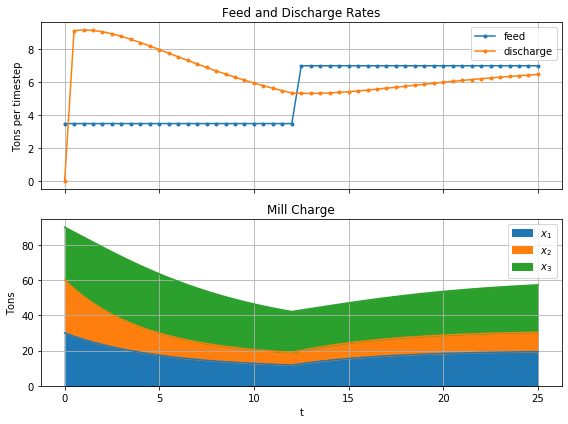

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True)

ax = axes[0]
ax.plot(t, feed_rates.sum(axis=1), '.-', label='feed')
ax.plot(t, discharge_rates.sum(axis=1), '.-', label='discharge')
ax.set_title('Feed and Discharge Rates')
ax.set_xlabel('t')
ax.set_ylabel('Tons per timestep')
ax.grid()
ax.legend()

ax = axes[1]
charge_weights.plot.area(ax=ax, stacked=True)
ax.set_title('Mill Charge')
ax.set_ylabel('Tons')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

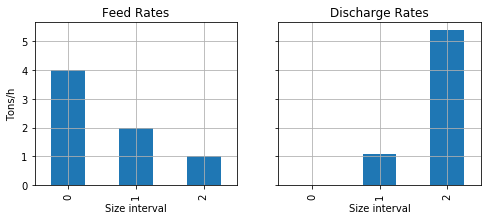

In [21]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8,3))

ax = axes[0]
pd.Series(feed_rates[-1]).plot.bar(ax=ax)
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons/h')
ax.set_title('Feed Rates')
ax.grid()

ax = axes[1]
pd.Series(discharge_rates[-1]).plot.bar(ax=ax)
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons/h')
ax.set_title('Discharge Rates')
ax.grid()

plt.show()

## Setup Full-Scale Simulation

In [22]:
from molycop.models import SAGMillRecycleModelDefault, SAGMillOpenModelDefault, \
                           StaticBreakageFunction
from molycop import mill_calcs

In [23]:
SAG_recycle_model = SAGMillRecycleModelDefault()
SAG_open_model = SAGMillOpenModelDefault()

In [24]:
# Comparison of discharge grates
models = [SAG_open_model, SAG_recycle_model]
pd.DataFrame({model.name: model.discharge_grate.params for model in models})

,Default SAG Mill - Open Circuit,Default SAG Mill with Pebble Crushing in Close Circuit
Opening (mm),12.7,50.8
% Open Area,12.0,15.0
Rate Constant (1/in^2/min),0.5,0.5
D50/DScreen,0.6,0.6
Bpf,0.4,0.4
m,2.0,2.0
D50 (microns),7620.0,30480.0
# of Grate Elements,NaN,36.0


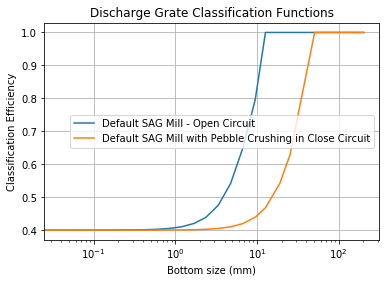

In [44]:
for model in models:
    x = model.discharge_grate.bottom_sizes
    y = model.discharge_grate.class_efficiencies
    plt.plot(x*1e-3, y, label=model.name)
plt.title('Discharge Grate Classification Functions')
plt.xscale('log')
plt.xlabel('Bottom size (mm)')
plt.ylabel('Classification Efficiency')
plt.grid()
plt.legend()
plt.show()

In [42]:
# Choose which one to use
class_efficiency = SAG_open_model.discharge_grate.class_efficiencies
class_efficiency.head()

Size Interval
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: Opening, dtype: float64

## Discharge rate function from Morrell

In [33]:
# Parameter values from Morrell (2004), 'A new autogenous and 
# semi-autogenous mill model for scale-up, design and optimisation'
# (see Fig. 1)
rate_max = 30  # 1/hr
size_max = 12  # mm
x_m = 1  # Size below which slurry flow constraint dominates

# Calculate discharge rate
size = 10
rate = rate_max * (1 - np.log(size) / np.log(size_max / x_m))
rate

2.201147759126192

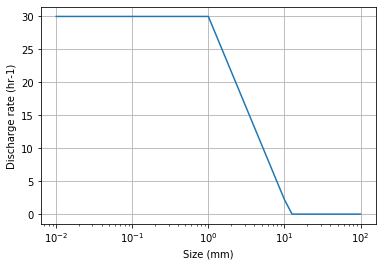

In [40]:
def calculate_discharge_rates(sizes, rate_max, size_max, x_m=1000):
    rates = rate_max * (1 - np.log(sizes) / np.log(size_max / x_m))
    return np.clip(rates, 0, rate_max)

sizes = np.logspace(-2,2,41)
rates = calculate_discharge_rates(sizes, 30, 12, x_m=1)

plt.plot(sizes,rates)
plt.xscale('log')
plt.xlabel('Size (mm)')
plt.ylabel('Discharge rate (hr-1)')
plt.grid()

## Set up mesh sizes for full model

In [28]:
mesh_dimensions = {
    'Size Interval': np.arange(1, 27),
    'Size': [
        16, 8, 4, 3, 2, 1.05, 0.742, 0.525, 0.371,
        3, 4, 6, 8, 10, 14, 20, 28, 35, 48, 65,
        100, 150, 200, 270, 400, -400
    ],
    'Opening': [
        406400, 203200, 101600, 76100, 50800,
        25400, 19050, 12700, 9500, 6700,
        4750, 3350, 2360, 1700, 1180,
        850, 600, 425, 300, 212,
        150, 106, 75, 53, 38, 0
    ]
}

mesh = pd.DataFrame(mesh_dimensions).set_index('Size Interval')
mesh.head()

,Size,Opening
Size Interval,,
1,16.0,406400
2,8.0,203200
3,4.0,101600
4,3.0,76100
5,2.0,50800


In [29]:
mesh_openings = (mesh['Opening'].iloc[:-1]).values
mesh_openings

array([406400, 203200, 101600,  76100,  50800,  25400,  19050,  12700,
         9500,   6700,   4750,   3350,   2360,   1700,   1180,    850,
          600,    425,    300,    212,    150,    106,     75,     53,
           38])

In [30]:
mid_sizes = mill_calcs.calculate_mesh_mid_sizes(mesh['Opening'])

In [ ]:
## Calcula

In [31]:
# Deafult selection and breakage model from Molycop Tools SAGSim model
selection_params = {
    'Balls': {'alpha0': 0.00358000, 'alpha1': 0.650,
              'alpha2': 3.500, 'dcrit': 25400},
    'Rocks': {'alpha0': 0.00228000, 'alpha1': 0.650,
              'alpha2': 3.500, 'dcrit': 9500},
    'Self': {'alpha0': 0.00018, 'alpha1': 0.650}
}

breakage_params = {
    'beta00': 0.400,
    'beta01': 0.050,
    'beta1': 0.650,
    'beta2': 2.500,
    'beta30': 0.127,
    'beta31': 0.000
}
static_breakage_function = StaticBreakageFunction(selection_params, breakage_params)
static_breakage_function

In [32]:
b_matrix = static_breakage_function.calculate_breakage_matrix(mesh_openings)
b_matrix.shape

(25, 25)

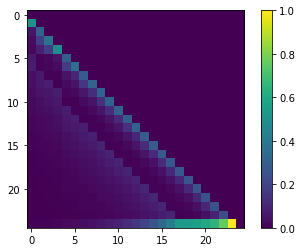

In [33]:
# Visualize B[i, j] matrix
plt.imshow(b_matrix, cmap='viridis')
plt.colorbar()
filename = "b_matrix_cmap.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

## Variable breakage rates model

In [34]:
from scipy.interpolate import CubicSpline

class DynamicBreakageFunctionMorrell2004:

    # Data from Morrell's SAG mill model paper (2004)
    default_selection_params = {
        'Sizes (mm)': [0.25, 4., 16., 45., 128.],
        'Charge Fillings (%)': {
            'Baseline': 20,
            'High load': 40
        },
        'Speeds (% Critical)': {
            'Baseline': 68,
            'High speed': 80
        },
        'Breakage Rates log(1/hour)': {
            'Baseline': [2.15, 3.92, 3.83, 3.15, 3.97],
            'High load': [3.09, 4.84, 3.72, 2.18, 2.99],
            'High speed': [2.04, 3.83, 3.85, 3.55, 4.8]
        }
    }

    default_breakage_params = {
        'beta00': 0.400,
        'beta01': 0.050,
        'beta1': 0.650,
        'beta2': 2.500,
        'beta30': 0.127,
        'beta31': 0.000
    }

    def __init__(self, selection_params=None, breakage_params=None):

        # TODO: Replace breakage matrix with JK (A, b) method
        if breakage_params is None:
            breakage_params = self.default_breakage_params
        self.breakage_params = breakage_params

        if selection_params is None:
            selection_params = self.default_selection_params
        self.selection_params = selection_params

        self.sizes = selection_params['Sizes (mm)']
        self.load_pcts = selection_params['Charge Fillings (%)']
        self.speed_pcts = selection_params['Speeds (% Critical)']
        self.load_range = (self.load_pcts['High load']
                           - self.load_pcts['Baseline'])
        self.speed_range = (self.speed_pcts['High speed']
                            - self.speed_pcts['Baseline'])
        index = pd.Index(self.sizes, name='Size (mm)')
        rate_data = selection_params['Breakage Rates log(1/hour)']
        assert all([name in rate_data for name in
                    ['Baseline', 'High load', 'High speed']])
        self.breakage_rate_pts = pd.DataFrame(rate_data, index=index)
        self.cubic_splines = None

    def make_cubic_splines(self, bc_type='natural'):

        self.cubic_splines = {}
        x_pts = self.breakage_rate_pts.index
        for label, y_pts in self.breakage_rate_pts.items():
            # Fit spline to log10(x) and log(y)
            cs = CubicSpline(np.log10(x_pts), y_pts, bc_type=bc_type)
            self.cubic_splines[label] = cs

    def show_cubic_splines_plot(self, show=True, filename=None,
                                title='Predicted Breakage Rates (Morrell, 2004)',
                                figsize=(8, 4)):

        x_pts = self.breakage_rate_pts.index.values
        x = np.logspace(np.log10(x_pts[0]), np.log10(x_pts[-1]))
        plt.figure(figsize=figsize)

        for label, y_pts in self.breakage_rate_pts.items():
            line, = plt.plot(x_pts, y_pts, marker='o', linestyle='')
            cs = self.cubic_splines[label]
            plt.plot(x, cs(np.log10(x)), color=line.get_color(), label=label)

        plt.title(title)
        plt.ylabel('log(rate) (1/hr)')
        plt.xlabel('size (mm)')
        plt.xscale('log')
        plt.legend()
        plt.grid()
        if filename:
            plt.savefig(filename)
        if show:
            plt.show()

    def get_breakage_rate_log(self, size, load_pct, speed_pct):
        """Calculates the log of the breakage rate for given size,
        load (%) and speed (% critical).  The units are log(1/hour)
        as per Morrell's breakage rate distribution plots (see 2004
        paper).
        """

        load_fraction = ((load_pct - self.load_pcts['Baseline'])
                         / self.load_range)
        speed_fraction = ((speed_pct - self.speed_pcts['Baseline'])
                          / self.speed_range)

        cs_baseline = self.cubic_splines['Baseline']
        cs_high_load = self.cubic_splines['High load']
        cs_high_speed = self.cubic_splines['High speed']

        log_10_size = np.log10(size)
        baseline_rate = cs_baseline(log_10_size)

        return (baseline_rate
                + load_fraction * (cs_high_load(log_10_size)
                                   - baseline_rate)
                + speed_fraction * (cs_high_speed(log_10_size)
                                    - baseline_rate))

    def get_breakage_rate(self, size, load_pct, speed_pct):
        """Uses the cubic splines with linear interpolation to
        estimate the breakage rate for given size, load (%)
        and speed (% critical).
        """

        return np.exp(self.get_breakage_rate_log(size, load_pct, speed_pct)) / 60

    def calculate_selection_matrix(self, mid_sizes, load_pct, speed_pct):
        """Calculates the selection matrix by interpolating
        between two of the breakage rate cubic splines estimated
        by Morrell (2004).

        The selection matrix that is returned contains four
        columns, one for the action of balls on particles, one
        for rocks on particles with rocks acting as grinding
        media, one for self-breakage of rocks, as a result
        of their own tumbling action, and the 'Overall'
        breakage function values that are used by the model.

        Args:
            mid_sizes (pd.Series): Pandas series containing the
                mid-sizes of each size interval.
            load_pct (float): Charge filling (%) .
            speed_pct (float): Speed (% critical).

        Returns:
            s (np.array): The selection function values by size
                interval.
        """

        return self.get_breakage_rate(mid_sizes*1e-3, load_pct, speed_pct)

    def calculate_breakage_matrix(self, mesh_openings):
        """Calculates the nxn breakage matrix based on the
        parameter values in self.breakage_params.
        """
        # TODO: Replace this with JK (A, b) method

        beta00 = self.breakage_params['beta00']
        beta01 = self.breakage_params['beta01']
        beta1 = self.breakage_params['beta1']
        beta2 = self.breakage_params['beta2']
        beta30 = self.breakage_params['beta30']
        beta31 = self.breakage_params['beta31']

        beta0j = beta00 * (mesh_openings / 100000) ** (-beta01)
        beta0j = beta0j.clip(None, 1)

        beta3j = beta30 * (mesh_openings / 100000) ** (-beta31)
        beta3j = beta3j.clip(None, 1)

        d_chips = mesh_openings * beta3j

        n = len(mesh_openings)

        # Calculate cumulative breakage distribution function
        b_cum = np.identity(n)
        ii, jj = np.tril_indices(n, k=-1)
        for i, j in zip(ii, jj):
            if mesh_openings[i] < d_chips[j + 1]:
                b_cum[i, j] = (
                    beta0j[j + 1]
                    * (mesh_openings[i] / d_chips[j + 1]) ** beta1
                    + (1 - beta0j[j + 1])
                    * (mesh_openings[i] / mesh_openings[j + 1]) ** beta2
                )
            else:
                b_cum[i, j] = (
                    beta0j[j + 1]
                    + (1 - beta0j[j + 1])
                    * (mesh_openings[i] / mesh_openings[j + 1]) ** beta2
                )

        # Calculate breakage matrix (differences)
        b_matrix = np.empty(b_cum.shape)
        b_matrix[:-1, :] = b_cum[:-1, :] - np.tril(b_cum[1:, :])
        b_matrix[-1, :] = b_cum[-1, :]
        b_matrix[-1, -1] = 0

        # Make sure all columns add to 1 (except last one)
        assert np.allclose(b_matrix[:, :-1].sum(axis=0), 1)

        return b_matrix

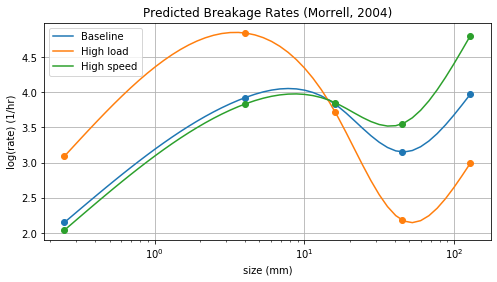

In [35]:
breakage_function = DynamicBreakageFunctionMorrell2004()
breakage_function.make_cubic_splines()
breakage_function.show_cubic_splines_plot()

In [36]:
def plot_rates(mid_sizes, r, ax=None, ylabel='Breakage rate (1/hr)',
               label=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(mid_sizes, r, marker='.', linestyle='-', label=label)
    ax.set_xlabel(mid_sizes.name)
    ax.set_ylabel(ylabel)
    ax.set_xscale('log')
    ax.set_yscale('log')
    return ax

In [37]:
mid_sizes_mm = mid_sizes * 1e-3
mid_sizes_mm.name = mid_sizes.name + ' (mm)'

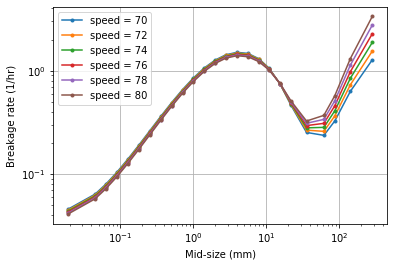

In [38]:
load_pct = 33
for speed_pct in [70, 72, 74, 76, 78, 80]:
    r = breakage_function.get_breakage_rate(mid_sizes_mm, load_pct, speed_pct)
    label = f'speed = {speed_pct}'
    plot_rates(mid_sizes_mm, r, label=label)
plt.grid()
plt.legend()
plt.show()

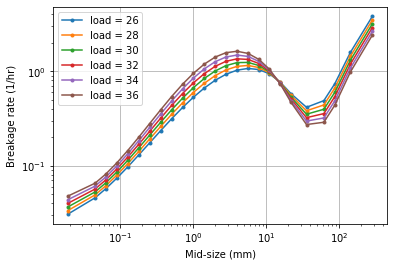

In [39]:
speed_pct = 78
for load_pct in [26, 28, 30, 32, 34, 36]:
    r = breakage_function.get_breakage_rate(mid_sizes_mm, load_pct, speed_pct)
    label = f'load = {load_pct}'
    plot_rates(mid_sizes_mm, r, label=label)
plt.grid()
plt.legend()
plt.show()

## Calculate filling level from charge weights

In [40]:
model = SAG_open_model
model.charge_filling_pct, model.balls_filling_pct

(28.0, 10.0)

In [41]:
model.charge_weights

{'Balls': 215.78803603902648,
 'Rocks': 140.33183246925077,
 'Slurry': 62.5484130712993}

In [42]:
model = SAG_open_model
model.params

{'Effective Diameter (ft)': 35.0,
 'Effective Length (ft)': 17.0,
 'Speed (% Critical)': 76.0,
 'Charge Filling (%)': 28.0,
 'Balls Filling (%)': 10.0,
 'Interstitial Filling (%)': 60.0,
 'Lift Angle (deg)': 45.0,
 'Power Loss (%)': 3,
 'Slurry Top Size (mm)': 12.699}

In [43]:
model.ore_density

2.8

In [44]:
def calculate_load_pct(charge_weight_rocks, model=None):
    if model:
        d = model.d
        length = model.length
        ore_density = model.ore_density
        ball_fill = model.balls_filling_pct
    else:
        d = 35
        length = 17
        ore_density = 2.8
        ball_fill = 10
    area = np.pi * (d * 0.305) ** 2
    rock_fill = (4 * charge_weight_rocks 
                 / (0.01 * (1 - 0.4) * ore_density * area
                    * (length * 0.305)))
    charge_filling_pct = ball_fill + rock_fill
    return charge_filling_pct

assert calculate_load_pct(100) == calculate_load_pct(100, model)

model.set_initial_conditions()
initial_charge = model.initial_charge
load_pct = calculate_load_pct(initial_charge.sum())
load_pct

34.005380143410655

## Feed Size Distribution

In [45]:
# Feed size distribution
passing_pct = [
    100.0, 95.48001354, 89.43643941, 80.01, 61.71896099,
    38.35445337, 32.89878606, 27.69288619, 25.01680918, 22.44064909,
    20.31138876, 18.40804667, 16.68227778, 15.19888032, 13.67911611,
    12.42220099, 11.19338884, 10.07870748, 9.050354653, 8.117299674,
    7.27326743, 6.5063266, 5.81611614, 5.191845859, 4.652694784, 0
]
assert passing_pct[0] == 100, \
    "The top mesh size must be set to 100% passing."
assert passing_pct[-1] == 0, \
    "The bottom mesh size must be set to 0% passing."

In [46]:
def calculate_feed_size_distribution(mesh, passing_pct):
    """Calculates the feed size distribution (as % passing) to
    the model's size_distributions dataframe and sets the
    retained_pct array.

    Args:
        passing_pct (list or array): Cumulative % passing
            values for each size interval.  The size of
            this array should match the number of rows
            in mesh_dimensions and the top and bottom
            size values should be 100, 0 respectively.
    """

    assert passing_pct[0] == 100, \
        "The top mesh size must be set to 100% passing."
    assert passing_pct[-1] == 0, \
        "The bottom mesh size must be set to 0% passing."
    passing_pct = np.array(passing_pct)
    feed_size_distribution = passing_pct[:-1]
    retained_pct = mill_calcs.calculate_retained_pct(passing_pct)
    fresh_feed = pd.Series(retained_pct * 0.01, index=mesh.index[:-1],
                           name='Fresh Feed, °/1')
    return fresh_feed

fresh_feed = calculate_feed_size_distribution(mesh, passing_pct)
fresh_feed

Size Interval
1     0.045200
2     0.060436
3     0.094264
4     0.182910
5     0.233645
6     0.054557
7     0.052059
8     0.026761
9     0.025762
10    0.021293
11    0.019033
12    0.017258
13    0.014834
14    0.015198
15    0.012569
16    0.012288
17    0.011147
18    0.010284
19    0.009331
20    0.008440
21    0.007669
22    0.006902
23    0.006243
24    0.005392
25    0.046527
Name: Fresh Feed, °/1, dtype: float64

## Initial Charge

In [47]:
model = SAG_open_model

model.set_initial_conditions()
model.initial_charge

Size Interval
1      8.459202
2     11.310613
3     17.641681
4     34.231872
5     43.726922
6     10.210339
7      9.742897
8      5.008306
9      4.821311
10     3.984933
11     3.562125
12     3.229795
13     2.776194
14     2.844255
15     2.352330
16     2.299735
17     2.086138
18     1.924573
19     1.746222
20     1.579615
21     1.435338
22     1.291736
23     1.168328
24     1.009027
25     8.707567
Name: Initial Charge, dtype: float64

## Simulation of Full System - Constant Breakage Rates

In [48]:
# Number of timesteps
nt = 50
timestep_size = 0.5  # mins

# Feedrate
feed_rates = np.repeat(fresh_feed.values.reshape(1,-1), nt+1, axis=0)

# Increase feedrate after 30 timesteps
feed_rates[25:] = 2 * feed_rates[25:]

# Discharge rate function
d_max = 1.0  # TODO: Is this already built into class efficienct?
c = 1 - class_efficiency  # Grate classification function
d = d_max * c

# Breakage rates
speed_pct = 68
load_pct = 20
breakage_rates = breakage_function.get_breakage_rate(mid_sizes_mm, load_pct, speed_pct)
r = timestep_size*breakage_rates/60

#assert r[-1] == 0.0  # r=0 for smallest size fraction
r[-1] = 0
assert all((r + d) <= 1)

# Initial charge
x0 = model.initial_charge.values
n_sizes = x0.shape[0]

# Initialize variables
x = np.zeros((nt+1, n_sizes))
discharge_rates = np.zeros((nt+1, n_sizes))
x[0] = x0

t = np.arange(nt+1) * timestep_size
for k in range(1, nt+1):
    feed = feed_rates[k]
    x[k, :] = solve(t[k], x[k-1], f_dxdt, timestep_size, args=[feed, r, b_matrix, d])
    discharge_rates[k] = d*x[k]

In [49]:
# Convert results to dataframe
labels = [('$x_{%d}$' % (i+1)) for i in range(n_sizes)]
index = pd.Index(t, name='t')
charge_weights = pd.DataFrame(x, columns=labels, index=index)
charge_weights.round(2).head()

,$x_{1}$,$x_{2}$,$x_{3}$,$x_{4}$,$x_{5}$,$x_{6}$,$x_{7}$,$x_{8}$,$x_{9}$,$x_{10}$,...,$x_{16}$,$x_{17}$,$x_{18}$,$x_{19}$,$x_{20}$,$x_{21}$,$x_{22}$,$x_{23}$,$x_{24}$,$x_{25}$
t,,,,,,,,,,,,,,,,,,,,,
0.0,8.46,11.31,17.64,34.23,43.73,10.21,9.74,5.01,4.82,3.98,...,2.30,2.09,1.92,1.75,1.58,1.44,1.29,1.17,1.01,8.71
0.5,8.41,11.33,17.67,34.29,43.81,10.24,9.77,4.54,4.06,3.19,...,1.72,1.56,1.44,1.31,1.18,1.07,0.96,0.87,0.75,6.49
1.0,8.37,11.34,17.69,34.35,43.89,10.28,9.79,4.12,3.43,2.55,...,1.29,1.17,1.08,0.98,0.88,0.80,0.72,0.65,0.56,4.84
1.5,8.33,11.36,17.71,34.40,43.98,10.31,9.82,3.74,2.90,2.05,...,0.97,0.88,0.81,0.73,0.66,0.60,0.54,0.49,0.42,3.62
2.0,8.28,11.37,17.73,34.46,44.06,10.34,9.84,3.40,2.45,1.65,...,0.74,0.67,0.61,0.55,0.50,0.45,0.41,0.37,0.32,2.71


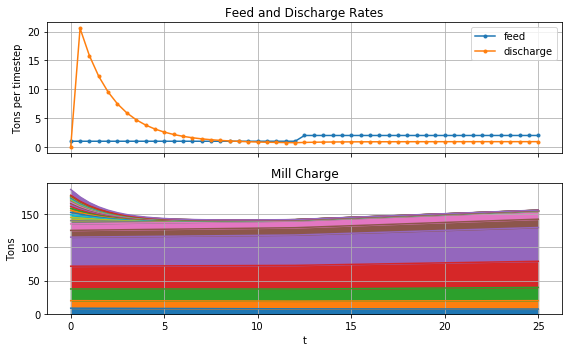

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(8,5), sharex=True)

style = '-' if charge_weights.shape[0] > 51 else '.-'

ax = axes[0]
ax.plot(t, feed_rates.sum(axis=1), style, label='feed')
ax.plot(t, discharge_rates.sum(axis=1), style, label='discharge')
ax.set_title('Feed and Discharge Rates')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons per timestep')
ax.grid()
ax.legend()

ax = axes[1]
charge_weights.plot.area(ax=ax, stacked=True, legend=False)
ax.set_title('Mill Charge')
ax.set_ylabel('Tons')
ax.grid()
#ax.legend()

plt.tight_layout()
filename = "demo_time_series.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

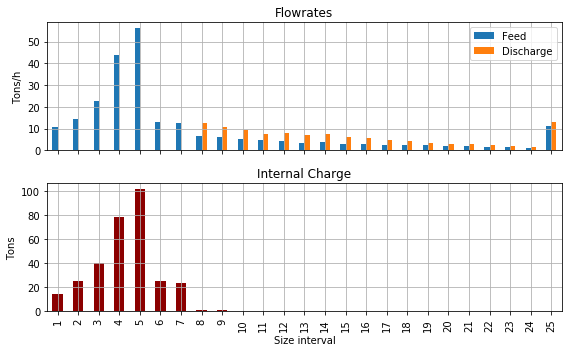

In [51]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8,5))

flow_rates = pd.DataFrame({
    'Feed': feed_rates[-1]*60/timestep_size,
    'Discharge': discharge_rates[-1]*60/timestep_size
})

ax = axes[0]
flow_rates.plot.bar(ax=ax)
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons/h')
ax.set_title('Flowrates')
ax.grid()

ax = axes[1]
pd.Series(charge_weights.values[-1]/timestep_size, index=mesh.index[:-1]).plot.bar(ax=ax, 
                                                                                   color='darkred')
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons')
ax.set_title('Internal Charge')
ax.grid()

plt.tight_layout()
filename = "demo_size_dist_plots.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

## Grinding Equations with Variable Breakage Rates

In [52]:
def f_dxdt_vr(t, x, feed, speed_pct, b_matrix, d, mid_sizes_mm):
    """Ordinary differential equations describing the rate of change of
    mill charge in each size fraction.  This is the 'General Grinding
    Model' described in Molycop Tools spreadsheet (Eq. 3).  Note, t is
    redundant in this case but is included for compatibility with
    numerical solvers which are designed for the general case where dxdt
    can be a function of time also.
    
    Args:
        t (float): Time (mins).
        x (array): Charge load (tons).
        feed (np.ndarray): Mill feed (tons).
        speed_pct (float): Rotational speed (% of critical speed).
        b_matrix (array): Breakage matrix (appearance functions).
        d (array): Discharge grate efficiencies.
        mid_sizes_mm (series): Mid-sizes of particles in milimeters.
    """
    load_pct = calculate_load_pct(x.sum())
    breakage_rates = breakage_function.get_breakage_rate(mid_sizes_mm, load_pct, speed_pct)
    r = breakage_rates * timestep_size / 60
    r[-1] = 0  # Smallest size has to be zero
    A = r*(b_matrix - np.eye(b_matrix.shape[0])) - np.diag(d)
    return feed + A @ x

In [53]:
# Test derivative calculations
speed_pct = 75
# Discharge rate function
d_max = 1  # Transport to grate TODO: Not sure what value to make this
c = 1 - class_efficiency  # Grate classification function
d = d_max * c

t = 0
dxdt = f_dxdt_vr(t, x0, feed, speed_pct, b_matrix, d, mid_sizes_mm)
dxdt

array([-0.04858203,  0.10955842,  0.16123163,  0.32851286,  0.42640921,
        0.11357137,  0.09047706, -0.97401407, -1.64806208, -1.7857457 ,
       -1.83335151, -1.77173216, -1.56862247, -1.63202463, -1.35635586,
       -1.32847945, -1.20494296, -1.11072902, -1.00673946, -0.91050633,
       -0.82697123, -0.74459156, -0.67392206, -0.58263342, -5.07224703])

In [54]:
# Test solver
t = 0
x0 = model.initial_charge.values
timestep_size = 0.5
x1 = solve(t, x0, f_dxdt_vr, timestep_size, args=[feed, speed_pct, b_matrix, d, mid_sizes_mm])
x1

array([ 8.43265866, 11.36498033, 17.72165581, 34.39529509, 43.93964964,
       10.26752764,  9.7886566 ,  4.54690022,  4.06794158,  3.18933713,
        2.75790314,  2.45908716,  2.09643099,  2.13847978,  1.76605096,
        1.72551584,  1.56514863,  1.44411563,  1.31055132,  1.1854816 ,
        1.07726088,  0.9692979 ,  0.87648279,  0.75672672,  6.51326488])

## Simulation of Full System - Variable Breakage Rates

In [55]:
# Number of timesteps
nt = 50
timestep_size = 0.5  # mins

# Control inputs
speed_pct_values = np.full((nt+1,), 68)
speed_pct_values[30:] = 80

# Feedrate
feed_rates = np.repeat(fresh_feed.values.reshape(1,-1), nt+1, axis=0)
#feed_rates[30:] = 2 * feed_rates[30:]

# Discharge rate function
d_max = 0.25  # Transport to grate TODO: Not sure what value to make this
c = 1 - class_efficiency  # Grate classification function
d = d_max * c

#assert r[-1] == 0.0  # r=0 for smallest size fraction
r[-1] = 0
assert all((r + d) <= 1)

# Initial charge
x0 = model.initial_charge.values
n_sizes = x0.shape[0]

# Initialize variables
x = np.zeros((nt+1, n_sizes))
discharge_rates = np.zeros((nt+1, n_sizes))
x[0] = x0

t = np.arange(nt+1) * timestep_size
for k in range(1, nt+1):
    feed = feed_rates[k]
    speed = speed_pct_values[k]
    x[k, :] = solve(t[k], x[k-1], f_dxdt_vr, timestep_size, args=[feed, speed, b_matrix, d, mid_sizes_mm])
    discharge_rates[k] = d*x[k]

In [56]:
# Convert results to dataframe
labels = [('$x_{%d}$' % (i+1)) for i in range(n_sizes)]
index = pd.Index(t, name='t')
charge_weights = pd.DataFrame(x, columns=labels, index=index)
charge_weights.round(2).head()

,$x_{1}$,$x_{2}$,$x_{3}$,$x_{4}$,$x_{5}$,$x_{6}$,$x_{7}$,$x_{8}$,$x_{9}$,$x_{10}$,...,$x_{16}$,$x_{17}$,$x_{18}$,$x_{19}$,$x_{20}$,$x_{21}$,$x_{22}$,$x_{23}$,$x_{24}$,$x_{25}$
t,,,,,,,,,,,,,,,,,,,,,
0.0,8.46,11.31,17.64,34.23,43.73,10.21,9.74,5.01,4.82,3.98,...,2.30,2.09,1.92,1.75,1.58,1.44,1.29,1.17,1.01,8.71
0.5,8.45,11.33,17.68,34.31,43.82,10.24,9.76,4.89,4.62,3.77,...,2.15,1.95,1.80,1.63,1.48,1.34,1.21,1.09,0.94,8.13
1.0,8.43,11.36,17.71,34.38,43.92,10.26,9.77,4.77,4.43,3.57,...,2.01,1.82,1.69,1.53,1.38,1.26,1.13,1.02,0.88,7.59
1.5,8.42,11.38,17.75,34.46,44.01,10.29,9.79,4.66,4.25,3.38,...,1.88,1.71,1.58,1.43,1.30,1.18,1.06,0.96,0.83,7.09
2.0,8.40,11.40,17.79,34.53,44.11,10.31,9.80,4.56,4.07,3.20,...,1.76,1.60,1.48,1.34,1.22,1.11,0.99,0.90,0.78,6.62


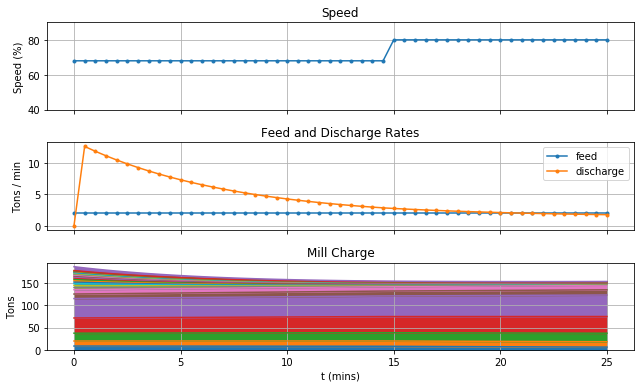

In [57]:
fig, axes = plt.subplots(3, 1, figsize=(9,5.5), sharex=True)

style = '-' if speed_pct_values.shape[0] > 51 else '.-'

ax = axes[0]
ax.plot(t, speed_pct_values, style, label='feed')
ax.set_ylim(40,90)
ax.set_title('Speed')
ax.set_xlabel('t')
ax.set_ylabel('Speed (%)')
ax.grid()

ax = axes[1]
ax.plot(t, feed_rates.sum(axis=1) / timestep_size, style, label='feed')
ax.plot(t, discharge_rates.sum(axis=1) / timestep_size, style, label='discharge')
ax.set_title('Feed and Discharge Rates')
ax.set_ylabel('Tons / min')
ax.grid()
ax.legend()

ax = axes[2]
charge_weights.plot.area(ax=ax, stacked=True, legend=False)
ax.set_title('Mill Charge')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons')
ax.grid()
#ax.legend()

plt.tight_layout()
filename = "demo_time_series_vr.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

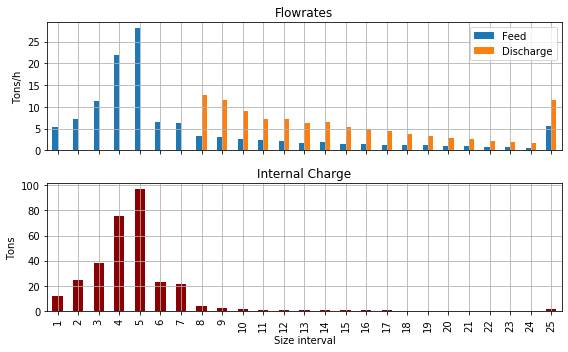

In [58]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8,5))

flow_rates = pd.DataFrame({
    'Feed': feed_rates[-1]*60/timestep_size,
    'Discharge': discharge_rates[-1]*60/timestep_size
})

ax = axes[0]
flow_rates.plot.bar(ax=ax)
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons/h')
ax.set_title('Flowrates')
ax.grid()

ax = axes[1]
pd.Series(charge_weights.values[-1]/timestep_size, index=mesh.index[:-1]).plot.bar(ax=ax, 
                                                                                   color='darkred')
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons')
ax.set_title('Internal Charge')
ax.grid()

plt.tight_layout()
filename = "demo_size_dist_plots_vr.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [59]:
def calculate_passing_pct(flows):
    """Calculates the cumulative size distribution
    (% passing) from the quantities in the series flows.

    Args:
        flows (pd.Series): Flow quantities (usually tons).
    """
    retained_pct = flows*100/flows.sum()
    return retained_pct[::-1].cumsum()[::-1]

In [60]:
calculate_passing_pct(feed_rates)

array([1.00000000e+02, 9.99087707e+01, 9.98981991e+01, ...,
       3.91960784e-01, 2.07128639e-01, 8.86271855e-02])

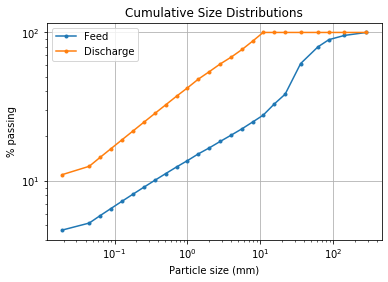

In [61]:
feed_passing_pct = calculate_passing_pct(feed_rates[-1])
discharge_passing_pct = calculate_passing_pct(discharge_rates[-1])

plt.plot(mid_sizes_mm, feed_passing_pct, label='Feed', marker='.')
plt.plot(mid_sizes_mm, discharge_passing_pct, label='Discharge', marker='.')
plt.title('Cumulative Size Distributions')
plt.xlabel('Particle size (mm)')
plt.ylabel('% passing')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

## Add stochastic elements and disturbances

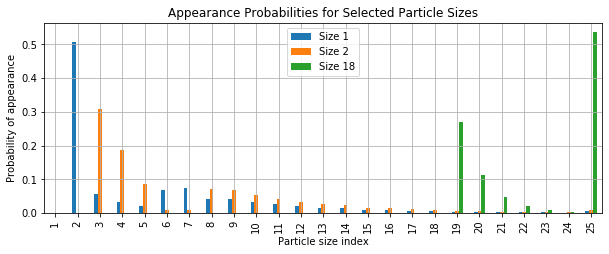

In [62]:
# Introduce randomness into rock breakage
sizes = [1, 2, 18]

plot_data = {}
for size in sizes:
    appearance_function = pd.Series(b_matrix[:, size-1], index=mesh.index[:-1])
    assert appearance_function.sum() == 1
    plot_data[f'Size {size}'] = appearance_function
df = pd.DataFrame(plot_data, index=mesh.index[:-1])

df.plot.bar(figsize=(10,3.5))
plt.title('Appearance Probabilities for Selected Particle Sizes')
plt.xlabel('Particle size index')
plt.ylabel('Probability of appearance')
plt.legend()
plt.grid()
plt.show()

In [63]:
# Use Dirichlet probability distribution
# From wikipedia: 
#   "This distribution can be used if one wanted to cut strings 
#   (each of initial length 1.0) into K pieces with different 
#   lengths, where each piece had, on average, a designated 
#   average length, but allowing some variation in the relative 
#   sizes of the pieces"

size = 1
appearance_function = pd.Series(b_matrix[size:, size-1], index=mesh.index[size:-1])
assert appearance_function.sum() == 1

n = 100
v = 100
samples = np.random.dirichlet(v*appearance_function.values, size=n)
print(samples.shape)
assert np.allclose(samples.sum(axis=1), 1)

means = samples.mean(axis=0)
stds = samples.std(axis=0)
max_values = samples.max(axis=0)
min_values = samples.min(axis=0)

(100, 24)


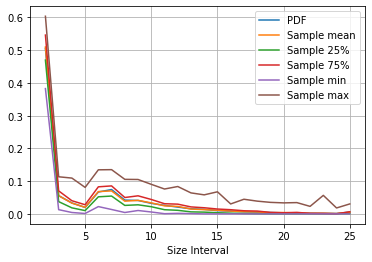

In [64]:
pd.DataFrame({
    'PDF': appearance_function,
    'Sample mean': means,
    'Sample 25%': np.quantile(samples, 0.25, axis=0),
    'Sample 75%': np.quantile(samples, 0.75, axis=0),
    'Sample min': min_values,
    'Sample max': max_values
}).plot(grid=True)
plt.show()

In [65]:
breakage_pdf = np.array([0.5, 0.3, 0.2])
assert sum(breakage_pdf) == 1
v = 100
samples = np.random.dirichlet(alpha=v*breakage_pdf, size=10)
assert np.allclose(samples.sum(axis=1), 1)
samples.round(2)

array([[0.5 , 0.32, 0.18],
       [0.45, 0.32, 0.23],
       [0.51, 0.22, 0.27],
       [0.44, 0.32, 0.24],
       [0.56, 0.3 , 0.14],
       [0.4 , 0.33, 0.27],
       [0.49, 0.28, 0.24],
       [0.63, 0.25, 0.12],
       [0.53, 0.23, 0.24],
       [0.53, 0.27, 0.2 ]])

In [66]:
assert breakage_pdf.sum() == 1
results = {}
for v in [0.1, 1,  10, 100, 1000]:
    samples = np.random.dirichlet(v*breakage_pdf, size=n)
    assert np.allclose(samples.sum(axis=1), 1, rtol=0.01)
    results[v] = samples
len(results)

5

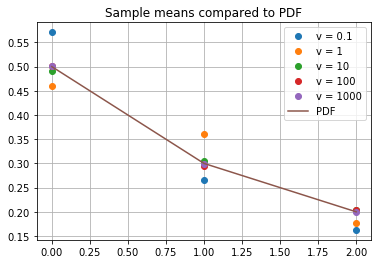

In [67]:
plt.figure()
for v, samples in results.items():
    plt.plot(samples.mean(axis=0), 'o', label=f'v = {v}')
plt.plot(breakage_pdf, '-', label='PDF')
plt.title('Sample means compared to PDF')
plt.grid()
plt.legend()
plt.show()

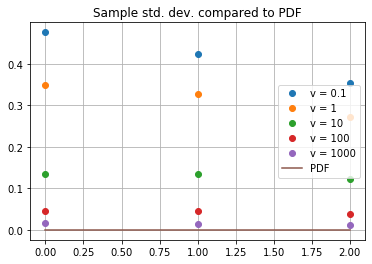

In [68]:
plt.figure()
for v, samples in results.items():
    plt.plot(samples.std(axis=0), 'o', label=f'v = {v}')
plt.plot(np.zeros(samples.shape[1]), '-', label='PDF')
plt.title('Sample std. dev. compared to PDF')
plt.grid()
plt.legend()
plt.show()

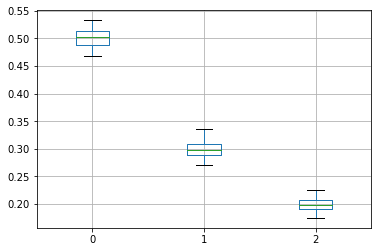

In [69]:
# Box plot doesn't handle these distributions too well...
pd.DataFrame(samples).boxplot()

In [70]:
breakage_pdf

array([0.5, 0.3, 0.2])

In [71]:
np.linalg.norm(breakage_pdf, ord=0)

3.0

In [72]:
np.linalg.norm(breakage_pdf, ord=1)

1.0

In [73]:
np.linalg.norm(breakage_pdf, ord=2)

0.6164414002968976

In [74]:
def sample_random_psd(psd_mean, v=100, size=1):
    nz = np.nonzero(psd_mean)
    assert len(nz) == 1, "psd_mean must be one-dimensional"
    norm = psd_mean.sum()
    psd = np.zeros((size, psd_mean.shape[0]))
    psd[:, nz[0]] = norm * np.random.dirichlet(v*psd_mean[nz]/norm, size=size)
    if size == 1:
        return psd.reshape(-1)
    else:
        return psd

feed = np.array([0.045, 0.   , 0.   , 0.183, 0.234, 0.055, 0.052, 0.027, 0.026,
       0.021, 0.019, 0.017, 0.015, 0.015, 0.013, 0.012, 0.011, 0.01 ,
       0.009, 0.008, 0.008, 0.007, 0.006, 0.005, 0.047])
feed_sample = sample_random_psd(feed)
assert feed_sample.shape == feed.shape
assert np.isclose(feed_sample.sum(), feed.sum())
feed_sample.round(3)

array([0.035, 0.   , 0.   , 0.166, 0.236, 0.036, 0.058, 0.006, 0.011,
       0.016, 0.034, 0.031, 0.032, 0.014, 0.009, 0.004, 0.018, 0.01 ,
       0.045, 0.005, 0.002, 0.002, 0.   , 0.003, 0.073])

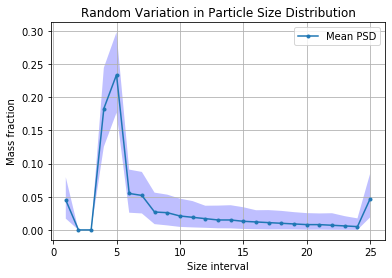

In [75]:
v = 100
random_samples = sample_random_psd(feed, v=v, size=1000)

i = mesh.index[0:-1]
low = np.quantile(random_samples, 0.05, axis=0)
high = np.quantile(random_samples, 0.95, axis=0)

plt.fill_between(i, low, high, facecolor='blue', alpha=0.25)
plt.plot(i, feed, marker='.', label='Mean PSD')
plt.title('Random Variation in Particle Size Distribution')
plt.xlabel('Size interval')
plt.ylabel('Mass fraction')
plt.grid()
plt.legend()
plt.show()

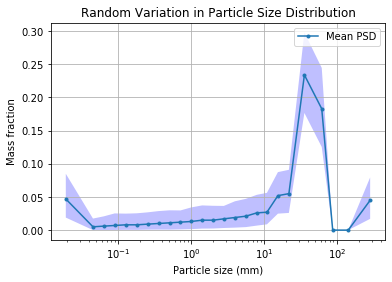

In [76]:
low = np.quantile(random_samples, 0.05, axis=0)
high = np.quantile(random_samples, 0.95, axis=0)

plt.fill_between(mid_sizes_mm, low, high, facecolor='blue', alpha=0.25)
plt.plot(mid_sizes_mm, feed, marker='.', label='Mean PSD')
plt.title('Random Variation in Particle Size Distribution')
plt.xscale('log')
plt.xlabel('Particle size (mm)')
plt.ylabel('Mass fraction')
plt.grid()
plt.legend()
plt.show()

In [77]:
def sample_random_b_matrix(b_matrix, v=100):
    """Randomize b_matrix"""
    random_b_matrix = np.zeros_like(b_matrix)
    for j in range(b_matrix.shape[1]):
        random_b_matrix[:, j] = sample_random_psd(b_matrix[:, j], v=v, size=1)
    return random_b_matrix

random_b_matrix = sample_random_b_matrix(b_matrix)
assert random_b_matrix.shape == b_matrix.shape
assert np.allclose(random_b_matrix[:,:-1].sum(axis=0), 1)

In [78]:
b_matrix[:5, :5].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.51, 0.  , 0.  , 0.  , 0.  ],
       [0.06, 0.31, 0.  , 0.  , 0.  ],
       [0.03, 0.19, 0.38, 0.  , 0.  ],
       [0.02, 0.09, 0.18, 0.48, 0.  ]])

In [79]:
random_b_matrix[:5, :5].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.56, 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.26, 0.  , 0.  , 0.  ],
       [0.01, 0.25, 0.37, 0.  , 0.  ],
       [0.04, 0.08, 0.2 , 0.54, 0.  ]])

## Simulation with Stochastic Breakage

In [80]:
# Number of timesteps
nt = 50
timestep_size = 0.5  # mins

# Control inputs
speed_pct_values = np.full((nt+1,), 68)
speed_pct_values[30:] = 80

# Feedrate
feed_rates = np.repeat(fresh_feed.values.reshape(1,-1), nt+1, axis=0)
#feed_rates[30:] = 2 * feed_rates[30:]

# Discharge rate function
d_max = 0.25  # Transport to grate TODO: Not sure what value to make this
c = 1 - class_efficiency  # Grate classification function
d = d_max * c

#assert r[-1] == 0.0  # r=0 for smallest size fraction
r[-1] = 0
assert all((r + d) <= 1)

# Initial charge
x0 = model.initial_charge.values
n_sizes = x0.shape[0]

# Initialize variables
x = np.zeros((nt+1, n_sizes))
discharge_rates = np.zeros((nt+1, n_sizes))
x[0] = x0

t = np.arange(nt+1) * timestep_size
for k in range(1, nt+1):
    feed = feed_rates[k]
    speed = speed_pct_values[k]
    random_b_matrix = sample_random_b_matrix(b_matrix, v=100)
    args = [feed, speed, random_b_matrix, d, mid_sizes_mm]
    x[k, :] = solve(t[k], x[k-1], f_dxdt_vr, timestep_size, args=args)
    discharge_rates[k] = d*x[k]

In [81]:
# Convert results to dataframe
labels = [('$x_{%d}$' % (i+1)) for i in range(n_sizes)]
index = pd.Index(t, name='t')
charge_weights = pd.DataFrame(x, columns=labels, index=index)
charge_weights.round(2).head()

,$x_{1}$,$x_{2}$,$x_{3}$,$x_{4}$,$x_{5}$,$x_{6}$,$x_{7}$,$x_{8}$,$x_{9}$,$x_{10}$,...,$x_{16}$,$x_{17}$,$x_{18}$,$x_{19}$,$x_{20}$,$x_{21}$,$x_{22}$,$x_{23}$,$x_{24}$,$x_{25}$
t,,,,,,,,,,,,,,,,,,,,,
0.0,8.46,11.31,17.64,34.23,43.73,10.21,9.74,5.01,4.82,3.98,...,2.30,2.09,1.92,1.75,1.58,1.44,1.29,1.17,1.01,8.71
0.5,8.45,11.34,17.68,34.30,43.82,10.23,9.76,4.89,4.62,3.77,...,2.15,1.95,1.80,1.63,1.48,1.34,1.21,1.09,0.94,8.13
1.0,8.43,11.36,17.71,34.38,43.92,10.26,9.77,4.78,4.43,3.57,...,2.01,1.82,1.68,1.53,1.38,1.26,1.13,1.02,0.89,7.59
1.5,8.42,11.38,17.75,34.45,44.01,10.29,9.79,4.66,4.25,3.37,...,1.88,1.70,1.58,1.44,1.30,1.18,1.06,0.96,0.83,7.09
2.0,8.40,11.41,17.78,34.53,44.11,10.31,9.80,4.55,4.08,3.20,...,1.76,1.60,1.48,1.35,1.21,1.11,0.99,0.90,0.78,6.62


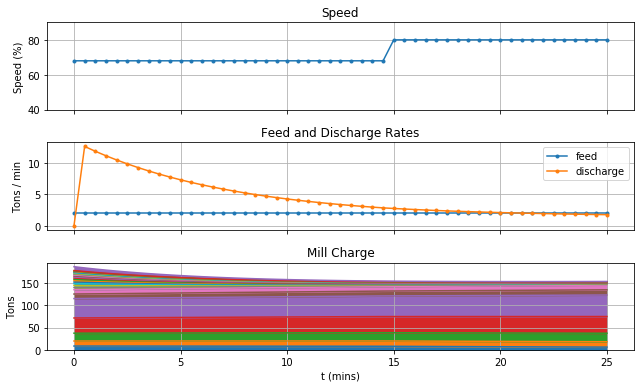

In [82]:
fig, axes = plt.subplots(3, 1, figsize=(9,5.5), sharex=True)

style = '-' if speed_pct_values.shape[0] > 51 else '.-'

ax = axes[0]
ax.plot(t, speed_pct_values, style, label='feed')
ax.set_ylim(40,90)
ax.set_title('Speed')
ax.set_xlabel('t')
ax.set_ylabel('Speed (%)')
ax.grid()

ax = axes[1]
ax.plot(t, feed_rates.sum(axis=1) / timestep_size, style, label='feed')
ax.plot(t, discharge_rates.sum(axis=1) / timestep_size, style, label='discharge')
ax.set_title('Feed and Discharge Rates')
ax.set_ylabel('Tons / min')
ax.grid()
ax.legend()

ax = axes[2]
charge_weights.plot.area(ax=ax, stacked=True, legend=False)
ax.set_title('Mill Charge')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons')
ax.grid()
#ax.legend()

plt.tight_layout()
filename = "demo_time_series_vrs.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

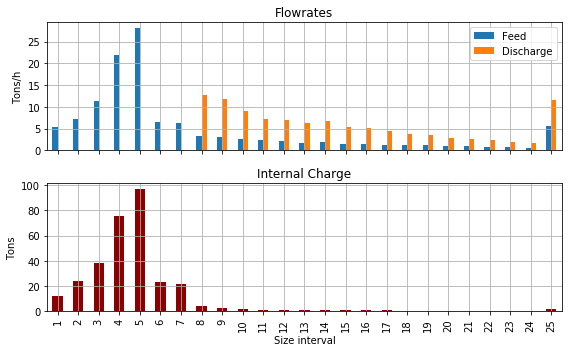

In [83]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8,5))

flow_rates = pd.DataFrame({
    'Feed': feed_rates[-1]*60/timestep_size,
    'Discharge': discharge_rates[-1]*60/timestep_size
})

ax = axes[0]
flow_rates.plot.bar(ax=ax)
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons/h')
ax.set_title('Flowrates')
ax.grid()

ax = axes[1]
pd.Series(charge_weights.values[-1]/timestep_size, index=mesh.index[:-1]).plot.bar(ax=ax, 
                                                                                   color='darkred')
ax.set_xlabel('Size interval')
ax.set_ylabel('Tons')
ax.set_title('Internal Charge')
ax.grid()

plt.tight_layout()
filename = "demo_size_dist_plots_vrs.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

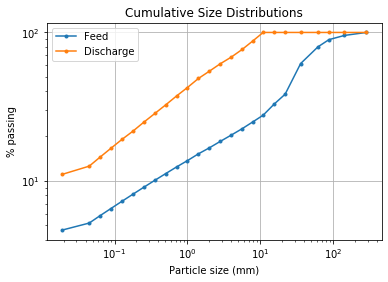

In [84]:
feed_passing_pct = calculate_passing_pct(feed_rates[-1])
discharge_passing_pct = calculate_passing_pct(discharge_rates[-1])

plt.plot(mid_sizes_mm, feed_passing_pct, label='Feed', marker='.')
plt.plot(mid_sizes_mm, discharge_passing_pct, label='Discharge', marker='.')
plt.title('Cumulative Size Distributions')
plt.xlabel('Particle size (mm)')
plt.ylabel('% passing')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()